In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# for "2. Data Loading"
import pandas as pd

# for "3-1. Feature Generation"
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.preprocessing import StandardScaler

In [4]:
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()

In [5]:
# 대형 : 1249.7087 사회스포츠 : 205.1269 숙박 : -127.4393
coef = [1249.7087 , 205.1269 , -127.4393 ]
coef = np.array(coef)
coef = coef.reshape(3,1)

In [6]:
scaler_coef = scaler.fit_transform(coef)
scaler_coef
scaler_coef.round(3)

array([[ 1.   ],
       [ 0.164],
       [-0.102]])

In [7]:
path = '/content/drive/MyDrive/데청캠 프로젝트/dataset/시군구별_인프라수_청년수.csv'
df = pd.read_csv(path, encoding='cp949')
df = df.drop(['Unnamed: 0'], axis=1)
df['청년인구'] = df['청년인구'].str.replace(",","")
df['청년인구'] = df['청년인구'].astype('float64')

In [8]:
df.columns

Index(['시군구', '청년인구', '병원', '사회스포츠', '대학교', '초중고', '공항', '소방서', '경찰서',
       '소형상업시설(음식점_카페_학원_편의점)', '대형상업시설', '숙박시설', '기차역', '행정기관', '법원, 교도소',
       '문화시설_영화/공연/미술관박물관', '버스터미널'],
      dtype='object')

In [9]:
df = df.drop([22,0,1])

In [10]:
df['다중지수'] = df['대형상업시설'] * 1 + df['사회스포츠'] * 0.164 +  df['숙박시설'] * -0.102
df['다중지수'] = df['다중지수'] / 6.7

In [11]:
df.sort_values(by=['다중지수'], axis=0, ascending=False)

,시군구,청년인구,병원,사회스포츠,대학교,초중고,공항,소방서,경찰서,소형상업시설(음식점_카페_학원_편의점),대형상업시설,숙박시설,기차역,행정기관,"법원, 교도소",문화시설_영화/공연/미술관박물관,버스터미널,다중지수
29,부산_진구,75731.0,832,188.0,3,111.0,0,0,10,6963,55,178,3,22.0,0.0,15.0,0.0,10.100896
7,서울_성북구,94117.0,539,141.0,6,108.0,0,1,12,5371,47,93,0,21.0,0.0,48.0,0.0,9.050448
16,서울_구로구,84959.0,574,128.0,3,89.0,0,1,9,5565,49,100,6,18.0,1.0,16.0,0.0,8.924179
23,서울_송파구,143645.0,1215,108.0,1,139.0,0,1,11,8807,46,52,1,29.0,2.0,37.0,0.0,8.717612
10,서울_노원구,101260.0,747,205.0,6,159.0,0,1,9,5218,25,26,3,21.0,0.0,19.0,0.0,8.353433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,울산_동구,26280.0,174,18.0,1,60.0,0,1,5,3107,3,71,0,10.0,0.0,4.0,0.0,-0.192537
70,울산_남구,64670.0,618,24.0,1,106.0,0,1,6,7460,16,244,4,16.0,2.0,18.0,3.0,-0.739104
73,울산_울주군,37605.0,206,57.0,2,107.0,0,1,11,4586,5,195,5,13.0,1.0,18.0,1.0,-0.827164
57,인천_강화군,7579.0,87,120.0,1,56.0,0,1,14,1998,2,305,1,14.0,1.0,19.0,1.0,-1.407463


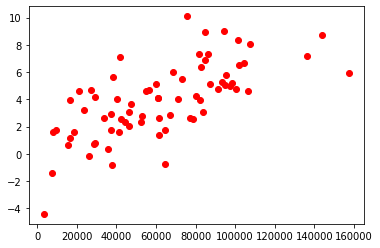

In [12]:
plt.plot(df['청년인구'], df['다중지수'], 'ro')

In [13]:
!pip install catboost
!pip install pycaret
!pip install optuna # 하이퍼 파라미터

In [14]:
from sklearn.preprocessing import StandardScaler

# for "4. Modeling with Pycaret"
from pycaret.regression import *

# for "5. Modeling with CatBoostRegressor"
from catboost import CatBoostRegressor
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.metrics import mean_absolute_error

In [15]:
path = '/content/drive/MyDrive/데청캠 프로젝트/dataset/시군구별_인프라수_청년수.csv'
df = pd.read_csv(path, encoding='cp949')
df = df.drop(['Unnamed: 0'], axis=1)
df['청년인구'] = df['청년인구'].str.replace(",","")
df['청년인구'] = df['청년인구'].astype('float64')
df = df.drop([22,0,1])

In [16]:
items = df.columns
need_list = ['대형상업시설', '사회스포츠', '숙박시설']
#need_list2 = ['병원',	'법원교도소',	'경찰서',	'소형상업시설' ,'숙박시설']
del_list = items.drop(need_list)

In [17]:
X = df[need_list]
y = df['청년인구']
df_data = pd.concat([y,X] , axis=1)


In [18]:
df_data = df_data.astype('float64')
std_scaler = StandardScaler()

In [20]:
df_data.loc[:,need_list] = std_scaler.fit_transform(df_data[need_list])
#df_data.columns = ['청년인구',	'병원',	'법원교도소',	'경찰서',	'소형상업시설' ,'숙박시설']
X = df_data[need_list]
y = df_data['청년인구']

In [21]:
reg = setup(df_data, 
            preprocess = False, # True로 설정되면, 자체적인 Feature Engineering을 추가로 진행해 Predict가 불가능해진다.
            train_size = 0.999,  # 우리는 전체 데이터를 학습해 test를 예측하는게 목표이기 때문에, 0.999로 설정한다.
            target = '청년인구', 
            silent = True, # 엔터를 누르기 귀찮다. 궁금하면 풀어보세요
            use_gpu = False, # GPU가 있으면 사용하세요 (Cat BOost 속도 향상)
            numeric_features=list(df_data.drop(columns = ['청년인구']).columns), # 모든 변수가 숫자로써의 의미가 있다.
            session_id = 2021,
            fold_shuffle = True
            )

,Description,Value
0,session_id,2021
1,Target,청년인구
2,Original Data,"(72, 4)"
3,Missing Values,False
4,Numeric Features,3
5,Categorical Features,0
6,Transformed Train Set,"(71, 3)"
7,Transformed Test Set,"(1, 3)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,False


In [22]:
top5 = compare_models(n_select = 5, sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,20183.7462,6.178482e+08,23870.0037,0.2566,0.5355,0.6232,0.355
br,Bayesian Ridge,20319.0023,6.684699e+08,24914.4672,0.1968,0.6290,0.5897,0.014
ridge,Ridge Regression,20328.9794,6.679251e+08,24902.0900,0.1939,0.5162,0.5980,0.014
llar,Lasso Least Angle Regression,20351.0572,6.687051e+08,24916.9387,0.1915,0.5184,0.6010,0.015
lasso,Lasso Regression,20351.9005,6.687070e+08,24917.3366,0.1914,0.5185,0.6011,0.014
lr,Linear Regression,20352.0406,6.687077e+08,24917.4077,0.1914,0.5185,0.6011,0.317
lar,Least Angle Regression,20352.0407,6.687076e+08,24917.4072,0.1914,0.5185,0.6011,0.016
huber,Huber Regressor,20428.2311,6.652194e+08,24817.7839,0.1959,0.5715,0.5867,0.019
rf,Random Forest Regressor,20569.5346,6.891645e+08,24988.7298,0.1596,0.5413,0.6389,0.412
ada,AdaBoost Regressor,21197.4352,7.016443e+08,25500.2784,0.1262,0.5516,0.6529,0.077


In [23]:
models = []
for m in top5:
    models.append(tune_model(m, 
                             optimize = 'MAE', 
                             choose_better = True,
                            n_iter = 10))

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,14226.8271,3.499268e+08,18706.3320,0.2905,0.3202,0.2631
1,15707.5234,2.930601e+08,17118.9980,0.6671,0.4008,0.3542
2,23004.3750,6.080148e+08,24657.9570,-0.1655,0.4405,0.4164
3,16178.3125,4.987360e+08,22332.3965,-0.1415,0.2331,0.1565
4,24501.2480,8.219966e+08,28670.4824,0.4065,0.8939,1.3236
5,12447.7451,2.416449e+08,15544.9307,0.6350,0.3714,0.3266
6,22482.8496,7.547648e+08,27472.9824,-0.4060,0.6119,0.7023
7,17875.1758,5.400574e+08,23239.1348,-0.1963,0.5737,0.4340
8,19689.2188,1.016062e+09,31875.7285,0.5501,0.4586,0.7141
9,37355.5859,1.562724e+09,39531.3008,0.2784,0.8736,1.3132


In [24]:
voting = blend_models(models, optimize = 'MAE')
voting = tune_model(voting, 
                 optimize = 'MAE', 
                 choose_better = True,
                 n_iter = 30)

voting = finalize_model(voting)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,13044.1447,2.417317e+08,15547.7235,0.5098,0.2580,0.2199
1,15864.3288,3.066746e+08,17512.1284,0.6516,0.3933,0.3549
2,22873.9198,6.006095e+08,24507.3350,-0.1513,0.4420,0.4214
3,17416.4052,4.551209e+08,21333.5624,-0.0417,0.2357,0.1782
4,22044.5829,6.513487e+08,25521.5346,0.5297,0.8815,1.2889
5,11564.4590,2.010596e+08,14179.5484,0.6963,0.3512,0.3093
6,21631.9266,6.537430e+08,25568.3979,-0.2178,0.5953,0.6916
7,16075.6706,4.136473e+08,20338.3200,0.0837,0.4830,0.3995
8,17888.0856,9.163173e+08,30270.7340,0.5943,0.4568,0.4353
9,37558.3740,1.568185e+09,39600.3217,0.2759,0.8702,1.3071


In [25]:
voting.weights

[0.99, 0.66, 0.23, 0.6900000000000001, 0.33]

In [26]:
layer1_pred = voting.predict(df_data.drop(columns = ['청년인구']))
layer1_pred

array([ 50704.51050421,  58417.83398335,  76629.71120257,  70994.1764105 ,
        64770.90122555, 101494.93497025,  68028.23117933,  62463.925794  ,
        98825.44274032,  82129.62172634,  65234.73336706,  80627.4873261 ,
        85680.53185115, 105378.41568146,  97845.78931107,  64332.03622053,
        80836.15605181,  79318.13208617, 105718.74566377,  87170.70145673,
       116548.67553375,  84409.9986051 ,  31682.07900711,  34427.31707382,
        28539.2709603 ,  31051.5390381 , 101313.29448417,  53022.80961188,
        55851.78187259,  52766.78059983,  77797.85056815,  64033.92565988,
        46774.88122027,  44449.16436848,  48531.22436721,  33799.56929546,
        55500.07290058,  53590.29149506,  47586.43447701,  48556.17160812,
        52604.83042329,  32545.773267  ,  89599.2387876 ,  74280.74861946,
       100318.85998275,  45851.94199278,  34343.75098862,  32282.3949749 ,
        83145.85007993,  60583.08481184,  90058.24878107,  80060.93185252,
        54633.09344319,  

## BayesianRidge

In [31]:
from sklearn.linear_model import BayesianRidge, LinearRegression

In [32]:
clf = BayesianRidge(compute_score=True)
clf.fit(X, y)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None, compute_score=True,
              copy_X=True, fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06,
              lambda_init=None, n_iter=300, normalize=False, tol=0.001,
              verbose=False)

In [33]:
clf.score(X, y)

0.46735883332275474

In [34]:
clf.coef_

array([16713.71621615,  9453.22537962, -7559.57449443])

In [35]:
coef = clf.coef_
coef = coef/5000
coef

array([ 3.34274324,  1.89064508, -1.5119149 ])

In [58]:
path = '/content/drive/MyDrive/데청캠 프로젝트/dataset/시군구별_인프라수_청년수.csv'
df = pd.read_csv(path, encoding='cp949')
df = df.drop(['Unnamed: 0'], axis=1)
df['청년인구'] = df['청년인구'].str.replace(",","")
df['청년인구'] = df['청년인구'].astype('float64')

In [59]:
df['청년인프라지수'] = df[need_list[0]] * coef[0] + df[need_list[1]] * coef[1] + df[need_list[2]] * coef[2]
df.sort_values(by=['청년인프라지수'], axis=0, ascending=False)

,시군구,청년인구,병원,사회스포츠,대학교,초중고,공항,소방서,경찰서,소형상업시설(음식점_카페_학원_편의점),대형상업시설,숙박시설,기차역,행정기관,"법원, 교도소",문화시설_영화/공연/미술관박물관,버스터미널,청년인프라지수
22,서울_강남구,108355.0,2741,261.0,0,119.0,0,1,16,15163,55,139,10,22.0,0.0,94.0,0.0,467.153072
10,서울_노원구,101260.0,747,205.0,6,159.0,0,1,9,5218,25,26,3,21.0,0.0,19.0,0.0,431.841034
61,광주_남구,38492.0,331,204.0,4,101.0,0,1,7,3509,8,35,1,17.0,0.0,17.0,0.0,359.516520
14,서울_양천구,84550.0,649,128.0,0,103.0,0,1,9,4716,27,17,0,20.0,1.0,9.0,0.0,306.554084
47,대구_달서구,107479.0,822,180.0,3,191.0,0,1,14,8913,35,101,0,24.0,3.0,15.0,0.0,304.608722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,서울_종로구,32943.0,496,28.0,3,60.0,0,1,23,5730,24,201,0,19.0,0.0,367.0,0.0,-170.730995
1,서울_중구,28277.0,572,16.0,2,48.0,0,1,17,5383,62,281,1,18.0,0.0,77.0,0.0,-187.347684
57,인천_강화군,7579.0,87,120.0,1,56.0,0,1,14,1998,2,305,1,14.0,1.0,19.0,1.0,-227.571149
70,울산_남구,64670.0,618,24.0,1,106.0,0,1,6,7460,16,244,4,16.0,2.0,18.0,3.0,-270.047862


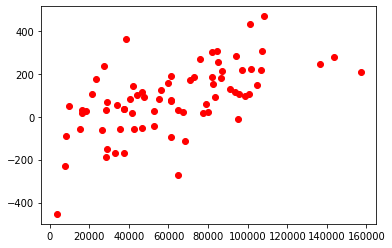

In [60]:
plt.plot(df['청년인구'], df['청년인프라지수'], 'ro')

In [61]:
df['청년인프라지수'] = df['청년인구'] / df['청년인프라지수'] / 44

In [62]:
df['청년인프라지수'].mean()

9.429284661900482

In [63]:
df.sort_values(by=['청년인프라지수'], axis=0, ascending=False)

,시군구,청년인구,병원,사회스포츠,대학교,초중고,공항,소방서,경찰서,소형상업시설(음식점_카페_학원_편의점),대형상업시설,숙박시설,기차역,행정기관,"법원, 교도소",문화시설_영화/공연/미술관박물관,버스터미널,청년인프라지수
52,인천_연수구,77245.0,407,50.0,1,110.0,0,1,6,5676,19,93,0,16.0,0.0,18.0,1.0,100.684733
5,서울_동대문구,80217.0,597,43.0,4,76.0,0,1,12,4902,33,112,7,16.0,0.0,21.0,0.0,81.850152
3,서울_성동구,67271.0,457,21.0,2,69.0,0,1,10,4562,22,62,3,19.0,0.0,31.0,0.0,78.383630
72,울산_북구,41455.0,172,30.0,0,94.0,1,1,5,3492,11,52,2,9.0,0.0,9.0,0.0,63.359923
74,세종시,64602.0,402,47.0,3,155.0,0,2,11,5922,10,61,8,21.0,1.0,26.0,3.0,48.841692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,대구_동구,61421.0,479,45.0,0,112.0,1,1,9,6397,18,159,4,24.0,0.0,19.0,4.0,-14.671462
65,대전_중구,42500.0,374,74.0,1,96.0,0,0,6,4330,24,185,1,18.0,0.0,28.0,1.0,-16.214504
30,부산_동래구,46382.0,488,21.0,0,80.0,0,0,7,4488,30,126,3,15.0,0.0,15.0,0.0,-20.867610
2,서울_용산구,52554.0,319,19.0,1,47.0,0,1,9,5056,23,104,9,18.0,1.0,48.0,0.0,-26.880643


In [64]:
df.to_csv('/content/drive/MyDrive/데청캠 프로젝트/다중회귀_BayesianRidge기반지수.csv', encoding='cp949')

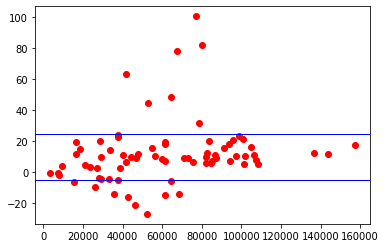

In [65]:
df = df.drop([18])
plt.plot(df['청년인구'], df['청년인프라지수'], 'ro')
plt.axhline(y=25, color='b', linewidth=1)
plt.axhline(y=-5, color='b', linewidth=1)

## huber

In [66]:
from sklearn.linear_model import HuberRegressor, LinearRegression

In [67]:
huber = HuberRegressor().fit(X, y)

In [68]:
huber.score(X, y)

0.4677695709425501

In [69]:
huber.predict(X)

array([ 50719.4509385 ,  54718.54466832,  69429.07488812,  67095.67483686,
        54822.54732758, 105276.04829052,  72024.38931437,  63009.94688991,
        96282.64121326,  74571.10794895,  61738.46336603,  74152.35626065,
        85930.62859375,  88919.35610612, 104681.2135536 ,  68819.25127045,
        74447.1970932 ,  69861.27989045,  78603.10202504,  89124.43883985,
       102794.56068809,  79615.80669996,  44936.46905869,  42994.22831781,
        35605.77397193,  38888.70878955, 114203.7776383 ,  57566.77248487,
        60608.30271783,  53234.74674878,  83537.912369  ,  69541.92945774,
        47846.41007664,  54644.92871224,  55089.73721176,  33151.49062054,
        63615.9400612 ,  66219.71827094,  64588.40193491,  42513.49191641,
        65266.91054855,  34817.44416646,  91909.61336302,  74906.06914535,
        95884.78162001,  45112.19009172,  37092.05942327,  44451.88474441,
        83110.41374117,  52465.95447945,  83915.6972249 ,  69463.95167624,
        51295.90140129,  

In [70]:
# 변수의 가중치값
huber.coef_

array([17422.77662568,  9020.85567391, -7737.66143488])

In [71]:
coef = huber.coef_
coef = coef/5000
coef

array([ 3.48455533,  1.80417113, -1.54753229])

In [82]:
path = '/content/drive/MyDrive/데청캠 프로젝트/dataset/시군구별_인프라수_청년수.csv'
df = pd.read_csv(path, encoding='cp949')
df = df.drop(['Unnamed: 0'], axis=1)
df['청년인구'] = df['청년인구'].str.replace(",","")
df['청년인구'] = df['청년인구'].astype('float64')
#df = df.drop([22,0,1])

In [83]:
coef[0]

3.484555325136939

In [84]:
df['청년인프라지수'] = df[need_list[0]] * coef[0] + df[need_list[1]] * coef[1] + df[need_list[2]] * coef[2]
df.sort_values(by=['청년인프라지수'], axis=0, ascending=False)

,시군구,청년인구,병원,사회스포츠,대학교,초중고,공항,소방서,경찰서,소형상업시설(음식점_카페_학원_편의점),대형상업시설,숙박시설,기차역,행정기관,"법원, 교도소",문화시설_영화/공연/미술관박물관,버스터미널,청년인프라지수
22,서울_강남구,108355.0,2741,261.0,0,119.0,0,1,16,15163,55,139,10,22.0,0.0,94.0,0.0,447.432221
10,서울_노원구,101260.0,747,205.0,6,159.0,0,1,9,5218,25,26,3,21.0,0.0,19.0,0.0,416.733126
61,광주_남구,38492.0,331,204.0,4,101.0,0,1,7,3509,8,35,1,17.0,0.0,17.0,0.0,341.763724
14,서울_양천구,84550.0,649,128.0,0,103.0,0,1,9,4716,27,17,0,20.0,1.0,9.0,0.0,298.708850
47,대구_달서구,107479.0,822,180.0,3,191.0,0,1,14,8913,35,101,0,24.0,3.0,15.0,0.0,290.409480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,울산_울주군,37605.0,206,57.0,2,107.0,0,1,11,4586,5,195,5,13.0,1.0,18.0,1.0,-181.508265
1,서울_중구,28277.0,572,16.0,2,48.0,0,1,17,5383,62,281,1,18.0,0.0,77.0,0.0,-189.947404
57,인천_강화군,7579.0,87,120.0,1,56.0,0,1,14,1998,2,305,1,14.0,1.0,19.0,1.0,-248.527701
70,울산_남구,64670.0,618,24.0,1,106.0,0,1,6,7460,16,244,4,16.0,2.0,18.0,3.0,-278.544886


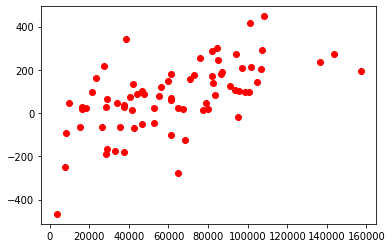

In [85]:
plt.plot(df['청년인구'], df['청년인프라지수'], 'ro')

In [86]:
df['청년인프라지수'] = df['청년인구']/ df['청년인프라지수']/ 618

In [87]:
df['청년인프라지수'].mean()

0.8868518951420087

In [88]:
df.sort_values(by=['청년인프라지수'], axis=0, ascending=False)

,시군구,청년인구,병원,사회스포츠,대학교,초중고,공항,소방서,경찰서,소형상업시설(음식점_카페_학원_편의점),대형상업시설,숙박시설,기차역,행정기관,"법원, 교도소",문화시설_영화/공연/미술관박물관,버스터미널,청년인프라지수
52,인천_연수구,77245.0,407,50.0,1,110.0,0,1,6,5676,19,93,0,16.0,0.0,18.0,1.0,10.003670
5,서울_동대문구,80217.0,597,43.0,4,76.0,0,1,12,4902,33,112,7,16.0,0.0,21.0,0.0,6.744285
3,서울_성동구,67271.0,457,21.0,2,69.0,0,1,10,4562,22,62,3,19.0,0.0,31.0,0.0,5.852044
72,울산_북구,41455.0,172,30.0,0,94.0,1,1,5,3492,11,52,2,9.0,0.0,9.0,0.0,5.597608
74,세종시,64602.0,402,47.0,3,155.0,0,2,11,5922,10,61,8,21.0,1.0,26.0,3.0,4.141251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,대구_동구,61421.0,479,45.0,0,112.0,1,1,9,6397,18,159,4,24.0,0.0,19.0,4.0,-0.972969
65,대전_중구,42500.0,374,74.0,1,96.0,0,0,6,4330,24,185,1,18.0,0.0,28.0,1.0,-0.994429
30,부산_동래구,46382.0,488,21.0,0,80.0,0,0,7,4488,30,126,3,15.0,0.0,15.0,0.0,-1.427795
2,서울_용산구,52554.0,319,19.0,1,47.0,0,1,9,5056,23,104,9,18.0,1.0,48.0,0.0,-1.828032


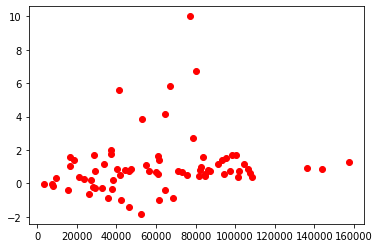

In [90]:
df = df.drop([18])
plt.plot(df['청년인구'], df['청년인프라지수'], 'ro')
#plt.axhline(y=5.8, color='b', linewidth=1)
#plt.axhline(y=3.8, color='b', linewidth=1)